<a href="https://colab.research.google.com/github/zaydmughal/Aadhaar-Mask/blob/main/Aadhaar_UID_Masking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install --upgrade pip
!pip install --upgrade Pillow
!pip install ordered-set

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 11 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,640 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

  Created wheel for ordered-set: filename=ordered_set-4.0.2-py2.py3-none-any.whl size=8209 sha256=2568769eaa9696c190aaa34cc60de2941d17d44c47b80e6748e4ec299db1c9f1
  Stored in directory: /root/.cache/pip/wheels/89/42/11/6ac0b34daaf88414eb260022bab0b52fa8b2a4fb3c2a76524d
Successfully built ordered-set


In [17]:
import cv2
from scipy import ndimage
from google.colab.patches import cv2_imshow
import pytesseract
from pytesseract import Output
import re
from ordered_set import OrderedSet

In [29]:
def gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
def thresh_hold(image):
    return cv2.threshold(image, 107, 255, cv2.THRESH_BINARY)[1]

#Check image Orientation and rotate image
def detect_angle(image):
    grey = gray(image)
    blur = cv2.GaussianBlur(grey, (3,3), 0)
    adaptive = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,15,4)
    newdata = pytesseract.image_to_osd(adaptive, nice=0)
    angle=(re.search('(?<=Rotate: )\d+', newdata).group(0))
    print("origional Image Orientation: ",angle)

    if (angle =='90'):
      return cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE)
      
      
    elif (angle=='270'):
      
      return cv2.rotate(image,cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
      return image

#Image Text Extract
def extract_text(img):
  image=gray(img)
  image=thresh_hold(img)
  t = pytesseract.image_to_string(image, lang='eng', config=r'--oem 3 --psm 12')
  return t
   
#Checking if it text from extract_text contains UID
def isAadhaar(text):
    text=text.split()
    num=OrderedSet()

    for word in text:
      if word.isdigit() and len(word) == 4 and len(num)<3:
        if word not in num:
            num.add(word)
    if(len(num)==3):
      return list(num)
    else:
      return "UID Not Found"


def box_extract( img):

  d = pytesseract.image_to_data(img, output_type=Output.DICT,config=r'--oem 3 --psm 12')
  return d

def imask(img):
  mask=gray(img)
  return thresh_hold(mask)


#Image Masking 
def mask_image(img, write, aadhaar_list):
        psm=[3,4,6]
        mask_count = 0
        mask=imask(img)

        for j in range(len(psm)):
            for i in range(len(aadhaar_list)-1):
                
                if (mask_aadhaar(img,mask,aadhaar_list[i],write) > 0):
                    mask_count += 1
                     
        cv2_imshow(img)
        cv2.imwrite(write,img)
        return mask_count

#Aadhar image UID Masking(First 8 DIGITS )
def mask_aadhaar(img,mask,uid, out_path):
    d = box_extract(mask)
    count = 0
    total_box = len(d['level'])
    color = (255, 255, 255) 
   
    for i in range(total_box):
        string = d['text'][i].strip()
        
        if string.isdigit() and len(string)>=2 and string in uid :
            
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            cv2.rectangle(img, (x, y), (x + w, y + h), color, cv2.FILLED)
            count += 1 
            
    return count 


In [24]:
def process_image(path,out):

    cv_img = cv2.imread(path)
    cv2_imshow(cv_img)
    img=detect_angle(cv_img)
    aadhaars = set()
    t = extract_text(img) 
    anum = isAadhaar(t)
    print(anum)

    if (anum!="UID Not Found"):
      
      mask_image(img,out,anum)
    else:
      print("UID Not Found")
      return

    



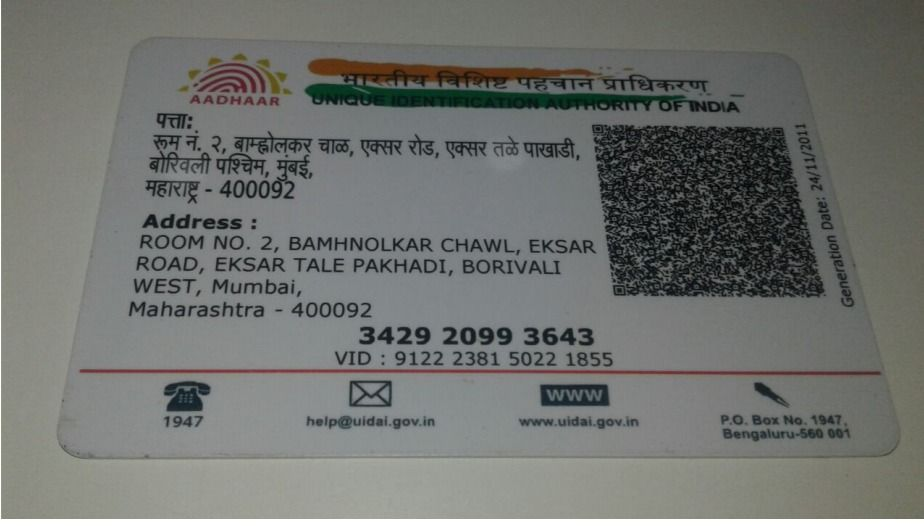

origional Image Orientation:  0
['3429', '2099', '3643']


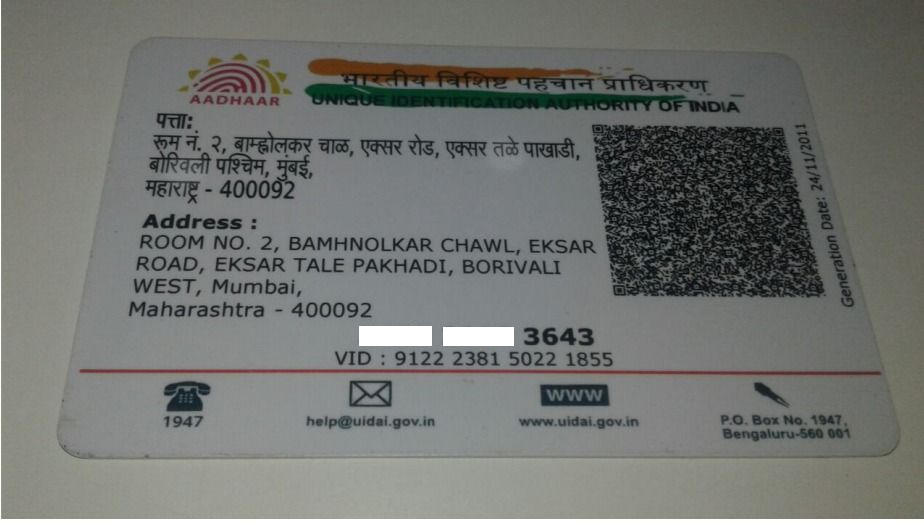

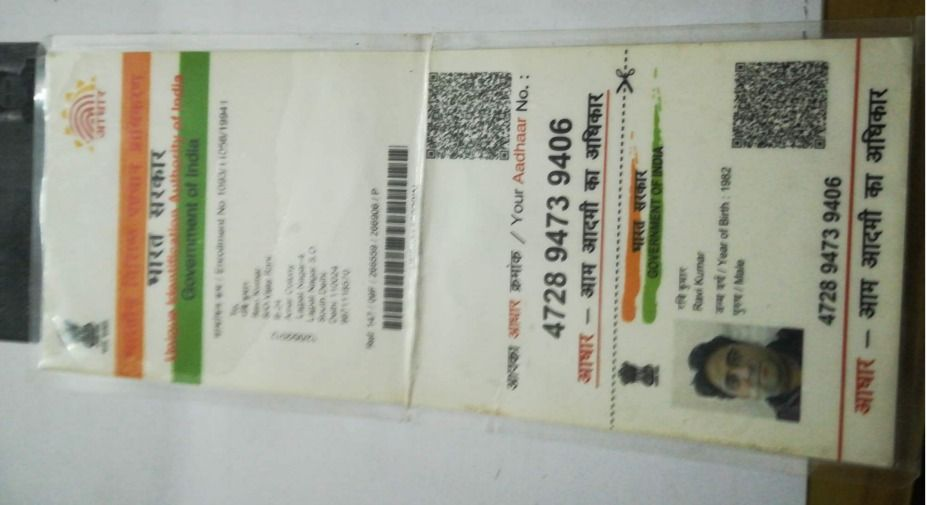

origional Image Orientation:  90
['4728', '9473', '9406']


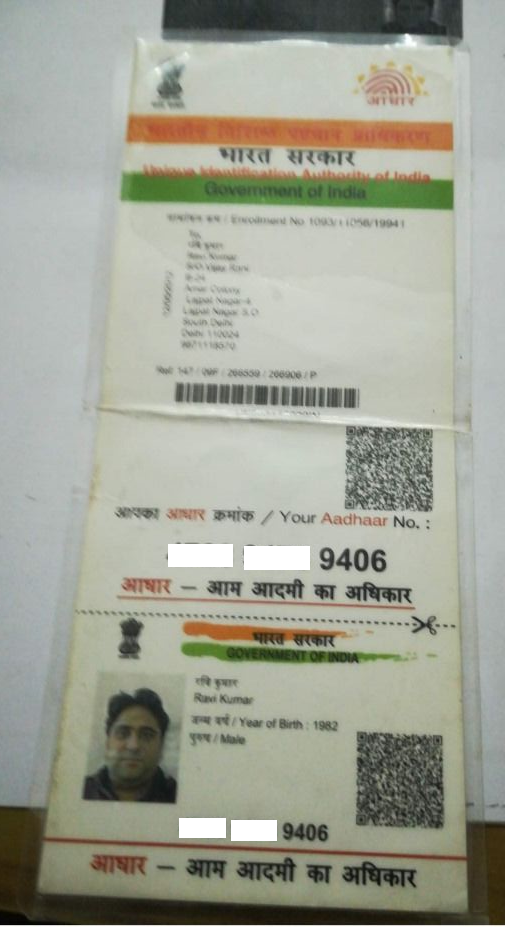

In [30]:
path='/content/drive/My Drive/adhar/img'
out='/content/drive/My Drive/adhar/out'
for i in range(1,3):
    process_image(path+str(i)+'.jpeg',out+str(i)+'.jpeg')

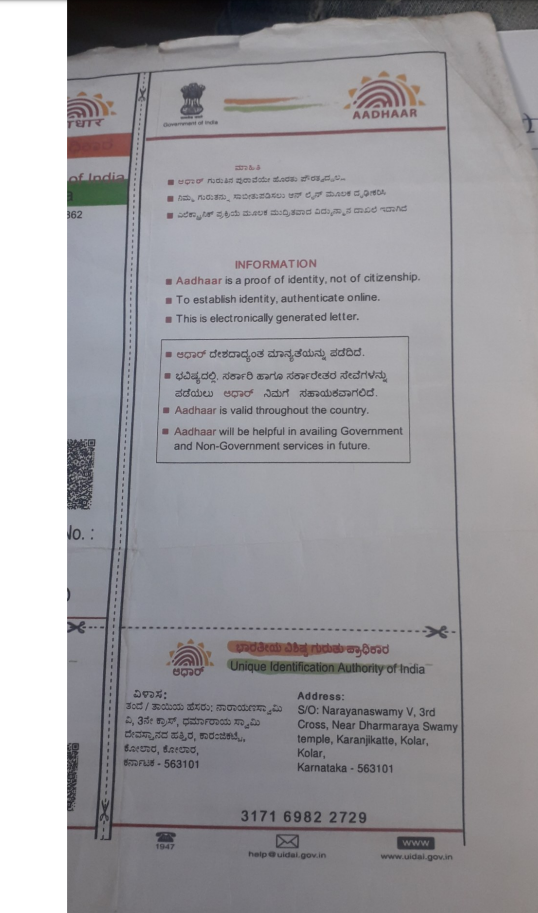

origional Image Orientation:  180
['3171', '6982', '2729']


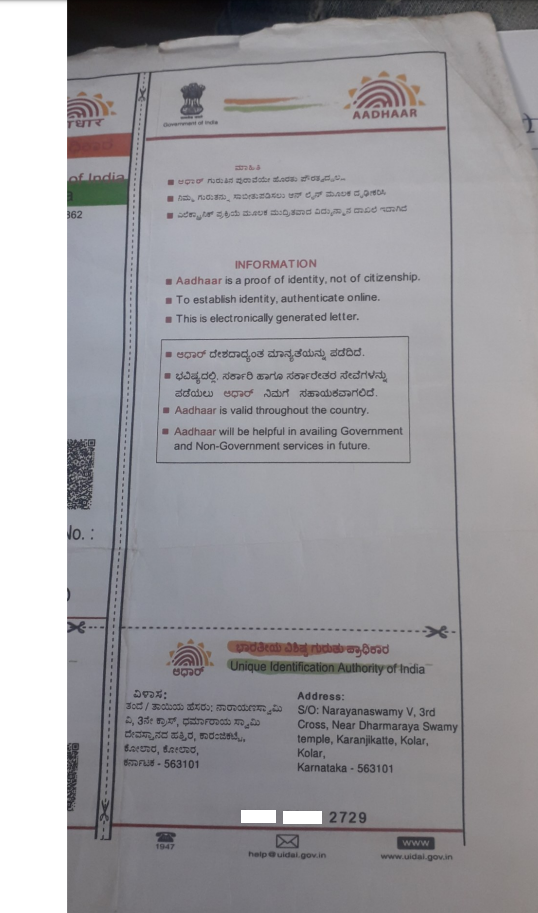

In [31]:
process_image(path+'3'+'.png',out+'3'+'.jpeg')